In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn
import scipy as sp

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy as sp
import scipy.interpolate as ip
import scipy.optimize as op
import scipy.signal as sg

import tqdm.auto as tqdm

np.random.seed(123)

In [1065]:
old_data_pars = dict(
                     # General parameters
                     td = 256, # Number of points
                     Fs = 12800, # Sampling frequency
                     debug = False, # Print data generation details

                     # Peak parameters
                     pmin = 1, # Minimum number of Gaussians in a peak
                     pmax = 1, # Maximum number of Gaussians in a peak
                     ds = 0.03, # Spread of chemical shift values for each peak
                     lw = [[5e1, 2e2], [1e2, 1e3]], # Linewidth range for Gaussians
                     iso_p = [0.8, 0.2],
                     iso_p_peakwise = True,
                     iso_int = [0.5, 1.], # Intensity
                     phase = 0., # Spread of phase

                     # Isotropic parameters
                     nmin = 1, # Minimum number of peaks
                     nmax = 15, # Maximum number of peaks
                     shift_range = [2000., 10000.], # Chemical shift range
                     positive = True, # Force the spectrum to be positive

                     # MAS-dependent parameters
                     mas_g_range = [[1e10, 1e11], [1e10, 5e11]], # MAS-dependent Gaussian broadening range
                     mas_l_range = [[1e7, 1e8], [1e7, 5e8]], # MAS-dependent Lorentzian broadening range
                     mas_s_range = [[-1e7, 1e7], [-1e7, 1e7]], # MAS-dependent shift range
                     mas_p = [0.8, 0.2],

                     # Second-order MAS-dependent parameters
                     mas_w2 = True,
                     mas_w2_p = 1.,
                     mas2_g_range = [[1e13, 1e15], [1e15, 1e16]], # MAS-dependent Gaussian broadening range
                     mas2_l_range = [[1e10, 1e12], [1e12, 1e13]], # MAS-dependent Lorentzian broadening range
                     mas2_s_range = [[-2e11, 2e11], [-2e11, 2e11]], # MAS-dependent shift range
                     mas2_p = [0.8, 0.2],

                     mas_phase = 0.1, # Random phase range for MAS spectra
                     peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                     encode_imag = False, # Encode the imaginary part of the MAS spectra
                     nw = 24, # Number of MAS rates
                     mas_w_range = [30000, 100000], # MAS rate range
                     random_mas = True,
                     encode_w = True, # Encode the MAS rate of the spectra

                     # Post-processing parameters
                     noise = 0., # Noise level
                     smooth_end_len = 10, # Smooth ends of spectra
                     iso_norm = 256., # Normalization factor for peaks
                     brd_norm = 64., # Normalization factor for MAS spectra
                     offset = 0., # Baseline offset
                     norm_wr = True, # Normalize MAS rate values
                     wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                    )

In [1066]:
old_dataset = data.PIPDataset(**old_data_pars)

In [1067]:
%%timeit
_ = old_dataset.__getitem__(0)

The slowest run took 15.72 times longer than the fastest. This could mean that an intermediate result is being cached.
514 ms ± 313 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1074]:
data_pars = dict(
                 # General parameters
                 td = 256, # Number of points
                 Fs = 12800, # Sampling frequency
                 debug = False, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 1, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [[5e1, 2e2], [1e2, 1e3]], # Linewidth range for Gaussians
                 iso_p = [0.8, 0.2],
                 iso_p_peakwise = True,
                 iso_int = [0.5, 1.], # Intensity
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 15, # Maximum number of peaks
                 shift_range = [2000., 10000.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive

                 # MAS-dependent parameters
                 mas_lw_range = [[1e7, 1e8], [5e7, 2e8]], # MAS-dependent GLS broadening range
                 mas_m_range = [[5e3, 5e4], [5e3, 5e4]], # MAS-dependent GLS mixing paramter
                 mas_s_range = [[-2e5, 2e5], [-2e5, 2e5]], # MAS-dependent shift range
                 mas_p = [0.8, 0.2],

                 # Second-order MAS-dependent parameters
                 mas_w2 = True,
                 mas_w2_p = 1.,
                 mas2_lw_range = [[1e11, 5e11], [1e11, 1e12]], # MAS-dependent Gaussian broadening range
                 mas2_m_range = [[5e8, 5e9], [5e8, 5e9]], # MAS-dependent Lorentzian broadening range
                 mas2_s_range = [[-5e9, 5e9], [-5e9, 5e9]], # MAS-dependent shift range
                 mas2_p = [0.8, 0.2],

                 mas_phase = 0.1, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 24, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = False,
                 encode_w = True, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 iso_norm = 256., # Normalization factor for peaks
                 brd_norm = 64., # Normalization factor for MAS spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                )

In [1075]:
importlib.reload(data)

dataset = data.PIPDatasetGLS(**data_pars)

In [1079]:
brd_specs, specs, iso = dataset.__getitem__(0)

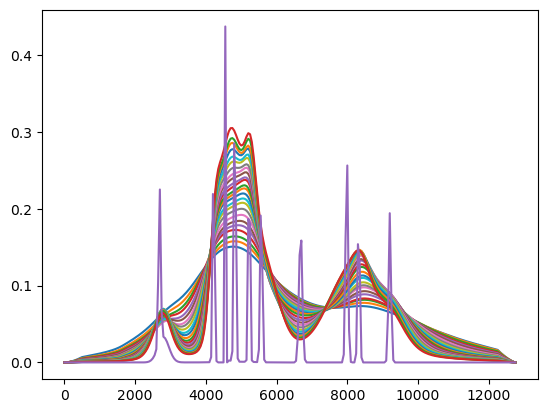

In [1080]:
plt.plot(dataset.f, brd_specs[:, 0, :].T)
plt.plot(dataset.f, iso[0])
#plt.xlim(3000, 4000)
plt.show()
plt.close()

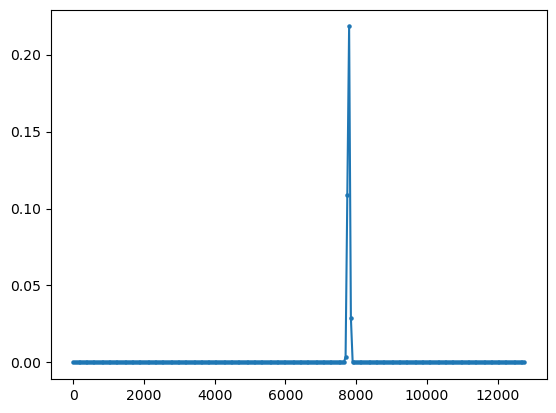

In [1072]:
plt.scatter(dataset.f, iso[0], s=5)
plt.plot(dataset.f, iso[0])
plt.show()
plt.close()

In [1073]:
%%timeit

_ = dataset.__getitem__(0)

3.8 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2]:
def voigt(x, p, wg, wl, h, eps=1e-12):
    
    G = np.exp(-4 * np.log(2) * np.square(x-p) / (wg ** 2))
    L = 1 / (1 + 4 * np.square(x-p) / (wl ** 2))
    
    print(np.max(G), np.max(L))
    
    V = sg.convolve(G, L, mode="same")
    
    print(np.max(V))
    
    if np.max(V) < eps:
        return V
    
    V /= np.max(V) / h
    
    return V

In [3]:
def gls(x, p, w, m, h):
    
    y = h * (1-m) * np.exp(-4 * np.log(2) * np.square(x-p) / (w ** 2))
    
    y += h * m / (1 + 4 * np.square(x-p) / (w ** 2))
    
    return y

In [4]:
def glp(x, p, w, m, h):
    
    y = h * np.exp(-4 * np.log(2) * (1-m) * np.square(x-p) / (w ** 2))
    
    y /= (1 + 4 * m * np.square(x-p) / (w ** 2))
    
    return y

In [5]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1 - y2)))

In [6]:
def to_minimize(x0, x, y, f):
    
    [p, w, m, h] = x0
    
    y2 = f(x, p, w, m, h)
    
    return rmse(y, y2)

# Make dummy signal

In [88]:
td = 256
Fs = 12800
t = np.arange(0., td, 1) / Fs
w0 = 8000. # Frequency, Hz
fid = np.exp(w0 * t * 2 * np.pi * 1j)
df = Fs / td
f = np.arange(0, td, 1) * df
spec = np.real(np.fft.fft(fid))

//anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


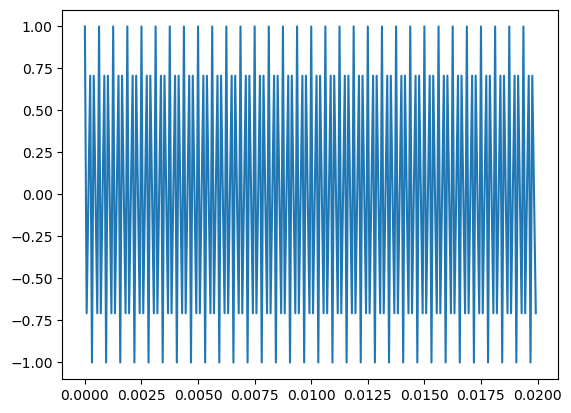

In [89]:
plt.plot(t, fid)
plt.show()
plt.close()

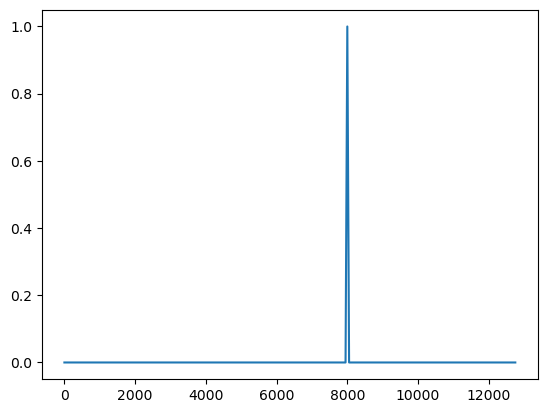

In [90]:
plt.plot(f, spec / np.max(spec))
plt.show()
plt.close()

In [91]:
win = glp(f, f[-1] / 2., 1000, 0., 1.)

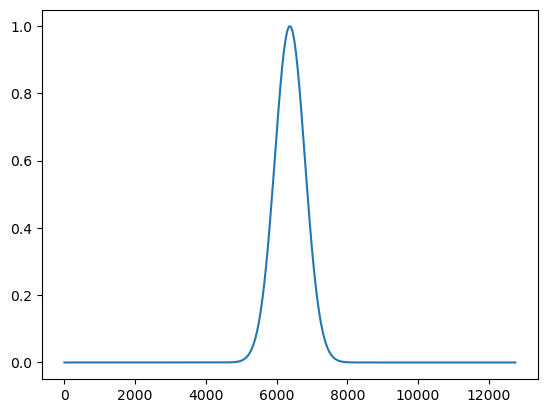

In [92]:
plt.plot(f, win)
plt.show()
plt.close()

In [93]:
spec2 = np.convolve(spec, win, mode="same")

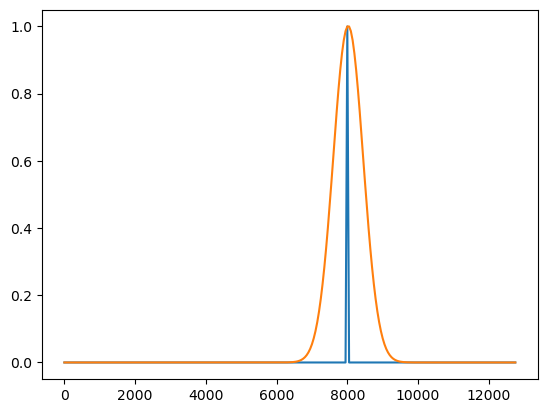

In [95]:
plt.plot(f, spec / np.max(spec))
plt.plot(f, spec2 / np.max(spec2))
plt.show()
plt.close()

In [17]:
%%timeit

gls(x, 0., 1., 0.5, 1.)

114 µs ± 5.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%%timeit

glp(x, 0., 1., 0.5, 1.)

111 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%%timeit

voigt(x, 0., 0.5, 0.5, 1.)

931 µs ± 63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
c0 = np.array([0., 1., 1.])
dc = np.array([0., -1., 0.])

for compound, ppm, X, ws in zip(exp_compounds, ppms, Xs, all_ws):
    print(compound)
    for r in fit_ranges[compound]:
        print(f"Fitting {r} ppm")
        
        r0 = np.min(r)
        r1 = np.max(r)
        
        fdir = f"{fig_dir}{compound}_{r0:.2f}_{r1:.2f}_ppm/"
        if not os.path.exists(fdir):
            os.mkdir(fdir)
        
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        for i, Xi in enumerate(X):
            ax.plot(ppm, Xi, color=c0 + i/(X.shape[0]-1) * dc, linewidth=1.)
        
        ax.set_xlim(20., -5.)
        ax.set_xlabel("Chemical shift [ppm]")
        ax.set_yticks([])
        fig.tight_layout()
        plt.savefig(f"{fdir}spectra.pdf")
        #plt.show()
        plt.close()
        
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        for i, Xi in enumerate(X):
            ax.plot(ppm, Xi, color=c0 + i/(X.shape[0]-1) * dc, linewidth=1.)
        
        ax.set_xlim(r1, r0)
        ax.set_xlabel("Chemical shift [ppm]")
        ax.set_yticks([])
        fig.tight_layout()
        plt.savefig(f"{fdir}spectra_zoom.pdf")
        #plt.show()
        plt.close()
        
        fit_v = []
        fit_s = []
        fit_p = []
        
        fit_rmses_v = []
        fit_rmses_s = []
        fit_rmses_p = []
        
        inds = np.where(np.logical_and(ppm > r0, ppm < r1))
        
        for i, (wi, Xi) in tqdm.tqdm(enumerate(zip(ws, X)), total=len(ws)):
            
            p0 = get_maximum(ppm, Xi, r, method="interp")
            
            bounds[0] = (r0, r1)
            bounds_v[0] = (r0, r1)
            
            best_res_v = None
            best_res_s = None
            best_res_p = None
            for w0 in w0s:
                
                for w02 in w0s:
                    x0 = [p0, w0, w02, np.max(Xi[inds])]
                    
                    res_v = op.minimize(to_minimize, x0, args=(ppm[inds], Xi[inds], voigt), bounds=bounds_v,
                                        method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})
                
                x0 = [p0, w0, 0.5, np.max(Xi[inds])]
                
                res_s = op.minimize(to_minimize, x0, args=(ppm[inds], Xi[inds], gls), bounds=bounds,
                                    method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})
                
                x0 = [p0, w0, 0.5, np.max(Xi[inds])]
                
                res_p = op.minimize(to_minimize, x0, args=(ppm[inds], Xi[inds], glp), bounds=bounds,
                                    method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})
                
                if best_res_v is None:
                    best_res_v = res_v
                    best_res_s = res_s
                    best_res_p = res_p
                
                if res_v.fun < best_res_v.fun:
                    best_res_v = res_v
                if res_s.fun < best_res_s.fun:
                    best_res_s = res_s
                if res_p.fun < best_res_p.fun:
                    best_res_p = res_p
            
            #res_s = op.minimize(to_minimize, x0, args=(ppm[inds], Xi[inds], gls), bounds=bounds,
            #                    method="trust-constr", options={'maxiter': 100000})
            #res_p = op.minimize(to_minimize, x0, args=(ppm[inds], Xi[inds], glp), bounds=bounds,
            #                    method="trust-constr", options={'maxiter': 100000})
            
            fit_v.append(best_res_v.x)
            fit_s.append(best_res_s.x)
            fit_p.append(best_res_p.x)
            
            y_v = voigt(ppm[inds], res_v.x[0], res_v.x[1], res_v.x[2], res_v.x[3])
            y_s = gls(ppm[inds], res_s.x[0], res_s.x[1], res_s.x[2], res_s.x[3])
            y_p = glp(ppm[inds], res_s.x[0], res_s.x[1], res_s.x[2], res_s.x[3])
            
            fit_rmses_v.append(rmse(Xi[inds], y_v))
            fit_rmses_s.append(rmse(Xi[inds], y_s))
            fit_rmses_p.append(rmse(Xi[inds], y_p))
            
            fig = plt.figure(figsize=(3,3))
            ax = fig.add_subplot(1,1,1)
            
            ax.plot(ppm[inds], Xi[inds])
            ax.plot(ppm[inds], y_v)
            ax.plot(ppm[inds], y_s)
            ax.plot(ppm[inds], y_p)
            ax.set_yticks([])
            ax.set_ylim(0 - np.max(X[:, inds]) * 0.05, np.max(X[:, inds]) * 1.05)
            ax.set_xlim(r1, r0)
            ax.set_xlabel("Chemical shift [ppm]")
            
            ax.legend(["Data", "Voigt", "GLS", "GLP"])
            ax.plot([r0, r1], [0., 0.], "k", linewidth=0.5)
            fig.tight_layout()
            
            plt.savefig(f"{fdir}fit_{wi:.0f}_kHz.pdf")
            #plt.show()
            plt.close()
            
        fit_v = np.array(fit_v)
        fit_s = np.array(fit_s)
        fit_p = np.array(fit_p)
        
        w_inds = np.where(ws >= min_w_fit)
        
        for i, (fit, yl) in enumerate(zip(fit_v.T, ylabs_v)):
            
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            P1, C1 = op.curve_fit(inverse_mas_fit, ws[w_inds], fit[w_inds])
            P2, C2 = op.curve_fit(inverse_mas2_fit, ws[w_inds], fit[w_inds])

            h0 = ax.scatter(ws / 1000, fit, s=5, c="C0")

            ax.set_ylabel(yl)
            ax.set_xlabel("MAS rate [kHz]")
            fig.tight_layout()
            plt.savefig(f"{fdir}Voigt_results_{yl}.pdf")
            
            h1 = ax.plot(ws / 1000, inverse_mas_fit(ws, P1[0], P1[1]), "C1")
            h2 = ax.plot(ws / 1000, inverse_mas2_fit(ws, P2[0], P2[1], P2[2]), "C2")

            ax.legend([h0, h1[0], h2[0]], ["Observed values", "1/w fit", "1/w + 1/w$^2$ fit"])

            ax.set_ylabel(yl)
            ax.set_xlabel("MAS rate [kHz]")
            fig.tight_layout()

            plt.savefig(f"{fdir}GLS_results_{yl}_fit.pdf")
            #plt.show()
            plt.close()
        
        for i, (fit, yl) in enumerate(zip(fit_s.T, ylabs_s)):
            
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            P1, C1 = op.curve_fit(inverse_mas_fit, ws[w_inds], fit[w_inds])
            P2, C2 = op.curve_fit(inverse_mas2_fit, ws[w_inds], fit[w_inds])

            h0 = ax.scatter(ws / 1000, fit, s=5, c="C0")

            ax.set_ylabel(yl)
            ax.set_xlabel("MAS rate [kHz]")
            fig.tight_layout()
            plt.savefig(f"{fdir}GLS_results_{yl}.pdf")
            
            h1 = ax.plot(ws / 1000, inverse_mas_fit(ws, P1[0], P1[1]), "C1")
            h2 = ax.plot(ws / 1000, inverse_mas2_fit(ws, P2[0], P2[1], P2[2]), "C2")

            ax.legend([h0, h1[0], h2[0]], ["Observed values", "1/w fit", "1/w + 1/w$^2$ fit"])

            ax.set_ylabel(yl)
            ax.set_xlabel("MAS rate [kHz]")
            fig.tight_layout()

            plt.savefig(f"{fdir}GLS_results_{yl}_fit.pdf")
            #plt.show()
            plt.close()
            
        for i, (fit, yl) in enumerate(zip(fit_p.T, ylabs_p)):
            
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            P1, C1 = op.curve_fit(inverse_mas_fit, ws[w_inds], fit[w_inds])
            P2, C2 = op.curve_fit(inverse_mas2_fit, ws[w_inds], fit[w_inds])

            h0 = ax.scatter(ws / 1000, fit, s=5, c="C0")
            
            ax.set_ylabel(yl)
            ax.set_xlabel("MAS rate [kHz]")
            fig.tight_layout()
            plt.savefig(f"{fdir}GLP_results_{yl}.pdf")
            
            h1 = ax.plot(ws / 1000, inverse_mas_fit(ws, P1[0], P1[1]), "C1")
            h2 = ax.plot(ws / 1000, inverse_mas2_fit(ws, P2[0], P2[1], P2[2]), "C2")

            ax.legend([h0, h1[0], h2[0]], ["Observed values", "1/w fit", "1/w + 1/w$^2$ fit"])

            ax.set_ylabel(yl)
            ax.set_xlabel("MAS rate [kHz]")
            fig.tight_layout()

            plt.savefig(f"{fdir}GLP_results_{yl}_fit.pdf")
            #plt.show()
            plt.close()
            
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        ax.plot(ws / 1000., fit_rmses_s)
        ax.plot(ws / 1000., fit_rmses_p)
        ax.legend(["GLS", "GLP"])
        ax.set_ylabel("RMSE")
        ax.set_xlabel("MAS rate [kHz]")
        fig.tight_layout()
        plt.savefig(f"{fdir}rmses.pdf")
        #plt.show()
        plt.close()
        
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        ax.plot(ws / 1000., fit_rmses_v)
        ax.plot(ws / 1000., fit_rmses_s)
        ax.plot(ws / 1000., fit_rmses_p)
        ax.legend(["Voigt", "GLS", "GLP"])
        ax.set_ylabel("RMSE")
        ax.set_xlabel("MAS rate [kHz]")
        fig.tight_layout()
        plt.savefig(f"{fdir}rmses_voigt.pdf")
        #plt.show()
        plt.close()

ampicillin
Fitting [9.5, 12.0] ppm


  0%|          | 0/41 [00:00<?, ?it/s]

//anaconda3/envs/torch/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
//anaconda3/envs/torch/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
//anaconda3/envs/torch/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


aspala
Fitting [12.0, 15.0] ppm


  0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-11-24404327c54a>:11: RuntimeWarning: divide by zero encountered in double_scalars
  V /= np.max(V) / h


KeyboardInterrupt: 